# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
df_offers.shape,df_transactions.shape

((32, 7), (324, 3))

In [5]:
# Merge the two dataframes based on 'offer_id'
df_merge_2=pd.merge(df_offers,df_transactions,on='offer_id')

# Pivot the table and fill NaN with zeros; reset index so that 'customer_name' is a column
df_pivot=pd.pivot_table(data=df_merge_2,index='customer_name',columns='offer_id',values='n',aggfunc='sum',fill_value=0).reset_index()
df_pivot.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

**What values of  SS do you believe represent better clusterings? Why?**<br>
The values of  SS will depend on the chosen number of clusters. As the number of clusters increases, the sum-of-squares will decrease till 0 when each data point is considered as an individual centroid, which is not what clustering aims for. If the SS is plotted against the number of clusters, it leads to a elbow shaped curve. The best clustering is when the number of clustering K takes a value such that the SS starts to decrease slowly, i.e., where the elbow of the curve lies.

In [6]:
# Subset columns representing the offers only
x_cols=df_pivot.iloc[:,1:]
x_cols.shape

(100, 32)

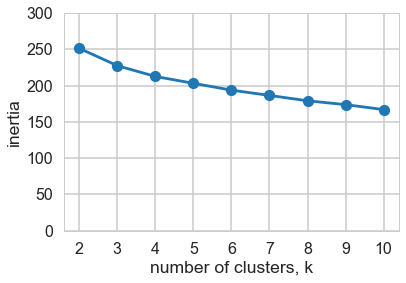

In [7]:
from sklearn.cluster import KMeans

# Calculate SS for each  K
ks=range(2,11)
inertias=[KMeans(n_clusters=k).fit(x_cols).inertia_ for k in ks]

# Plot k vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.ylim(0,300);

The inertia starts to drop slowly at k=3. It looks like k=3 is the elbow point. I would pick k=3 as the best number of centroid for this data set.

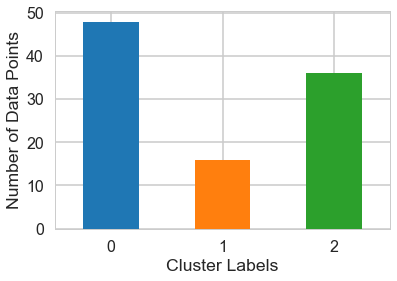

In [8]:
# Make a bar chart showing the number of points in each cluster for k-means under the best K
k_best=3
model=KMeans(n_clusters=k_best,random_state=123)
model.fit(x_cols)
pd.Series(model.labels_).value_counts().sort_index().plot(kind='bar',rot=0)
plt.xlabel('Cluster Labels')
plt.ylabel('Number of Data Points');

**What challenges did you experience using the Elbow method to pick K?**<br>
The choice of K by elbow Sum-of-Squares method is quite subjective. It might be different for different users.  

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713


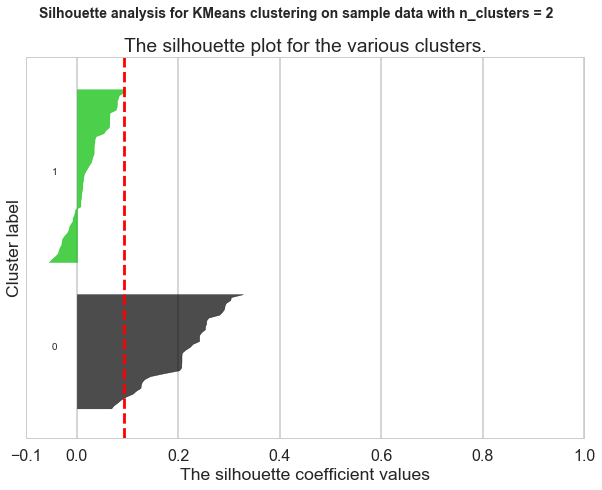

For n_clusters = 3 The average silhouette_score is : 0.11889942863638556


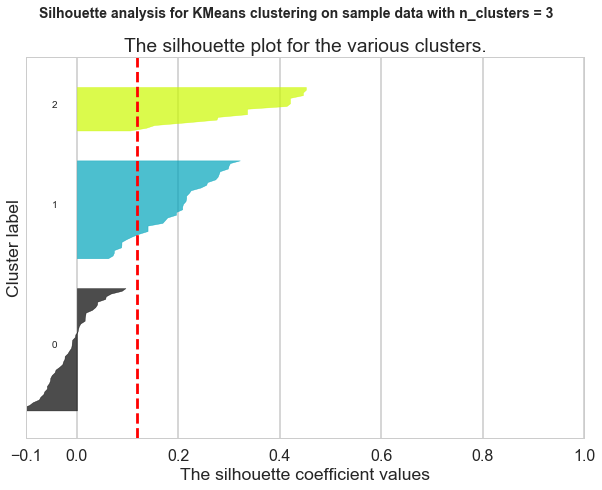

For n_clusters = 4 The average silhouette_score is : 0.12347053919571699


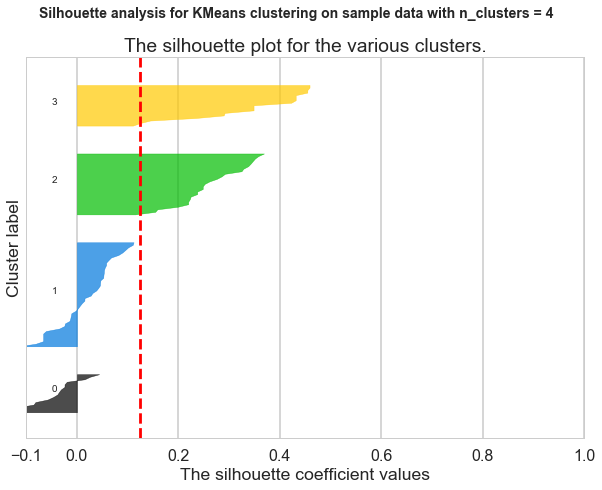

For n_clusters = 5 The average silhouette_score is : 0.14092516241984757


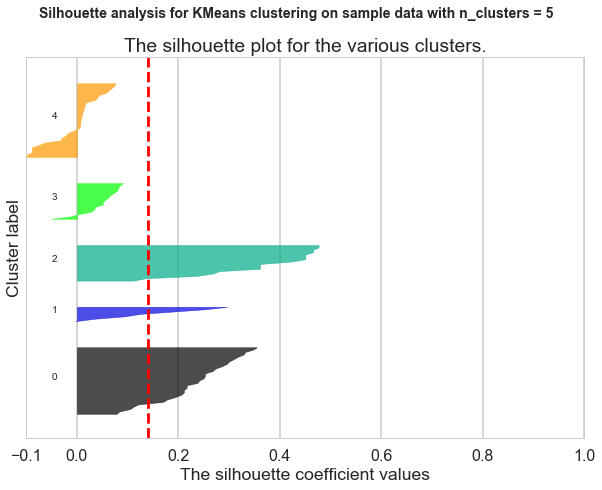

For n_clusters = 6 The average silhouette_score is : 0.1371798939109807


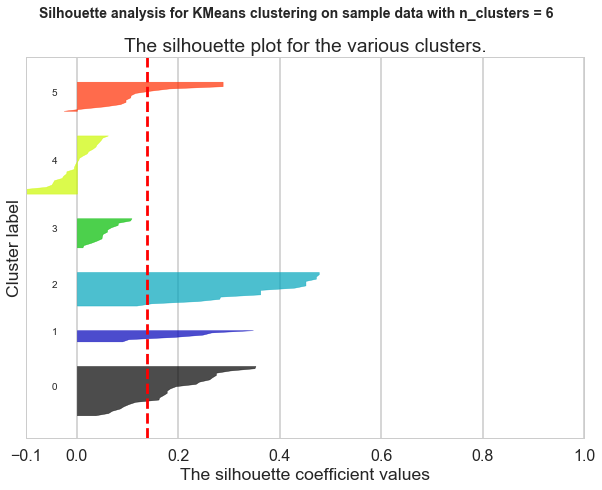

For n_clusters = 7 The average silhouette_score is : 0.1161092456616906


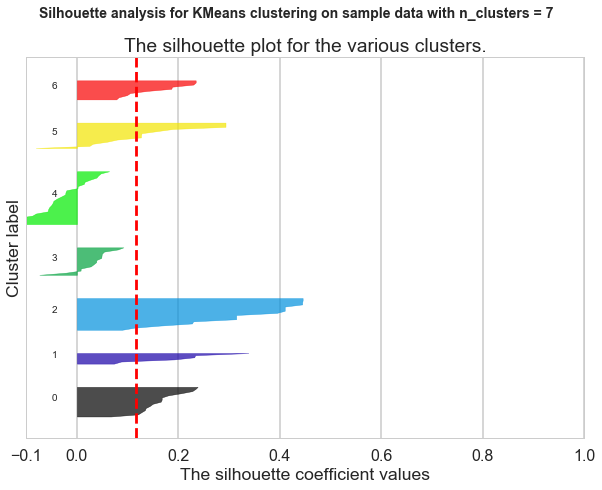

For n_clusters = 8 The average silhouette_score is : 0.11339573832632867


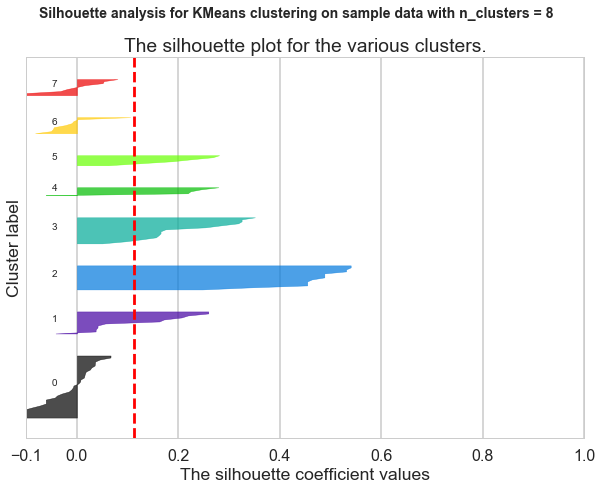

For n_clusters = 9 The average silhouette_score is : 0.12505960527779877


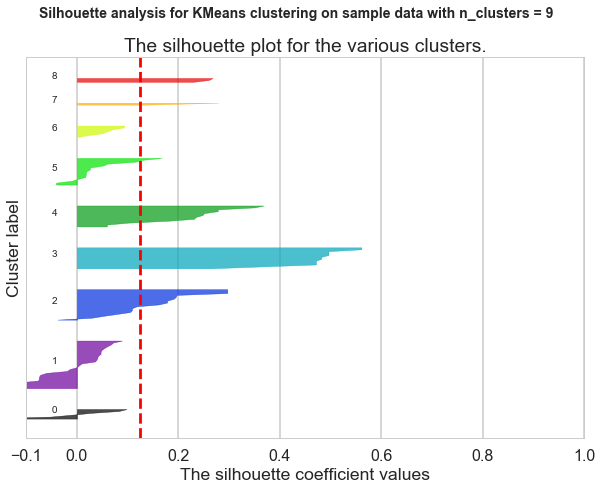

For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


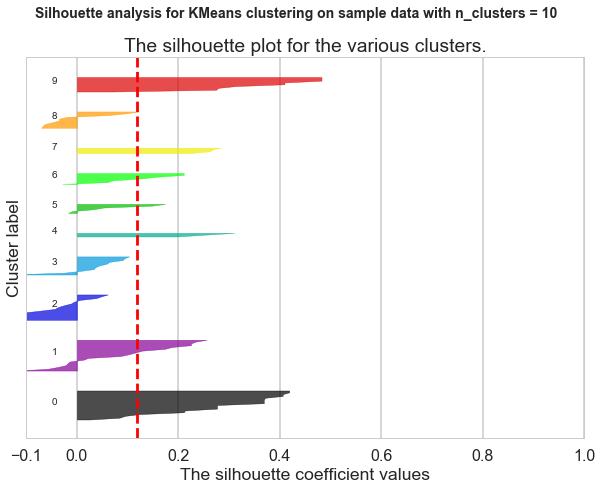

In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np


range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]
X=x_cols

score_avgs = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    score_avgs.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

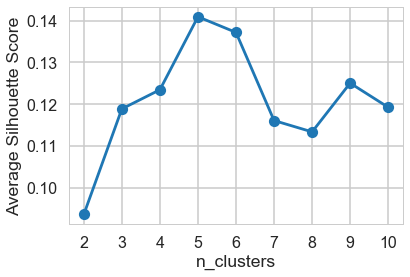

In [10]:
# Visualize the average silhouette score vs. clusters
plt.plot(range_n_clusters, score_avgs,'-o')
plt.xlabel('n_clusters')
plt.ylabel('Average Silhouette Score')
plt.xticks(range_n_clusters);

For all the trials with the number of clusters n_clusters in the range of [2,10], the highest average silhouette_score is around 0.14 for n_clusters=5.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

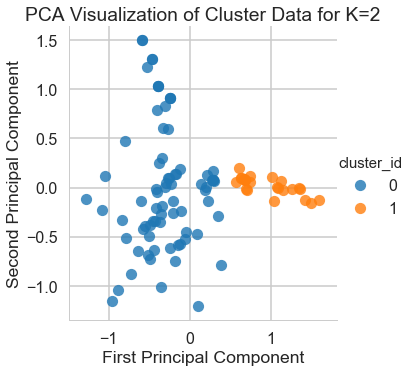

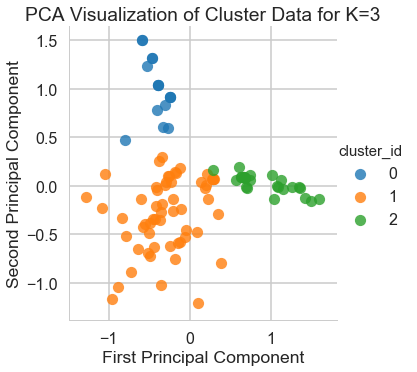

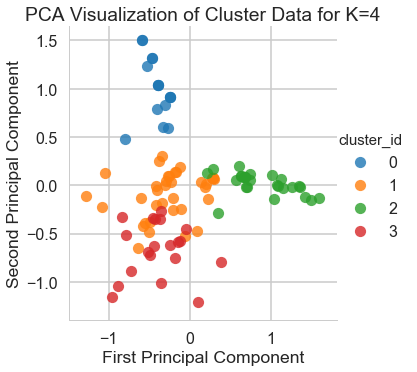

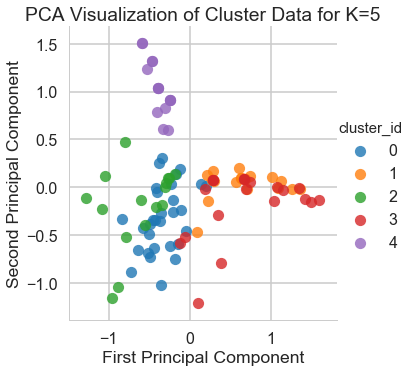

In [11]:
from sklearn.decomposition import PCA
model=PCA(n_components=2,random_state=123)
x_new=model.fit_transform(x_cols)
PCA_1=x_new[:,0]
PCA_2=x_new[:,1]

for k in range(2,6):
    cluster_id=KMeans(n_clusters=k).fit_predict(x_cols)
    df_PCA=pd.DataFrame(data={'customer_name':df_pivot.customer_name,'cluster_id': cluster_id,
                  'x':PCA_1,'y':PCA_2})
    ax=sns.lmplot('x','y',hue='cluster_id',data=df_PCA,fit_reg=False)
    ax.set_axis_labels('First Principal Component', 'Second Principal Component')  
    #ax.set_titles('PCA Visualization of Cluster Data for K={}'.format(k))
    plt.title('PCA Visualization of Cluster Data for K={}'.format(k))
    plt.show()
    

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

The PCA visualization of cluster data suggests that k=3 is the best value for the number of clusters, consistent with the elbow sum-of-squares method.

**Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?**

In [12]:
# Build a large data frame by merging the original raw data about the offers and transactions the fitted clusters.
from sklearn.decomposition import PCA
model=PCA(n_components=2,random_state=123)
x_new=model.fit_transform(x_cols)
PCA_1=x_new[:,0]
PCA_2=x_new[:,1]


cluster_id=KMeans(n_clusters=3,random_state=1111).fit_predict(x_cols)
df_PCA=pd.DataFrame(data={'customer_name':df_pivot.customer_name,'cluster_id': cluster_id,
                  'x':PCA_1,'y':PCA_2})

df_combined=pd.merge(df_merge_2,df_PCA,on='customer_name')
df_combined.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster_id,x,y
0,1,January,Malbec,72,56,France,False,Thomas,1,2,-1.041879,0.122314
1,4,February,Champagne,72,48,France,True,Thomas,1,2,-1.041879,0.122314
2,9,April,Chardonnay,144,57,Chile,False,Thomas,1,2,-1.041879,0.122314
3,11,May,Champagne,72,85,France,False,Thomas,1,2,-1.041879,0.122314
4,14,June,Merlot,72,64,Chile,False,Thomas,1,2,-1.041879,0.122314


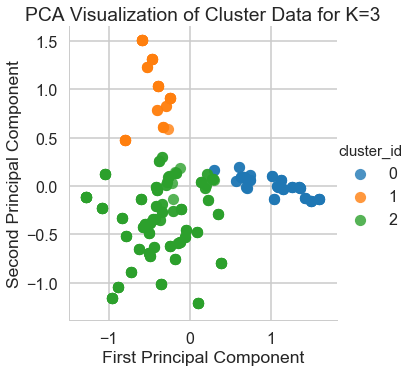

In [13]:
# Visualize the clusters using PCA
ax=sns.lmplot('x','y',hue='cluster_id',data=df_combined,fit_reg=False)
ax.set_axis_labels('First Principal Component', 'Second Principal Component')  
plt.title('PCA Visualization of Cluster Data for K={}'.format(3))
plt.show()
 

In [14]:
# Check number of unique values in relevant columns
{col:df_combined[col].nunique() for col in df_combined.columns[:-2]}

{'offer_id': 32,
 'campaign': 12,
 'varietal': 9,
 'min_qty': 4,
 'discount': 27,
 'origin': 9,
 'past_peak': 2,
 'customer_name': 100,
 'n': 1,
 'cluster_id': 3}

In [15]:
df_combined.cluster_id.value_counts(normalize=True)

2    0.641975
0    0.225309
1    0.132716
Name: cluster_id, dtype: float64

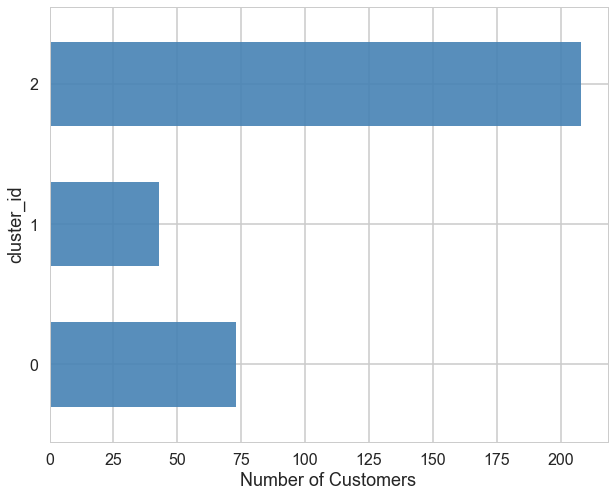

In [16]:
# Make a bar plot to visualize the number of customers in each cluster
df_combined.cluster_id.value_counts().sort_index().plot(kind='barh',figsize=(10,8),width=0.6,color='steelblue',alpha=0.9)
plt.ylabel('cluster_id',fontsize=18)
plt.xlabel('Number of Customers',fontsize=18);

We can tell that the third group (cluster_id=2) have the largest number of customers. Cluster_0 (cluster_id=0) has less customers and cluster_1's customers (cluster_id=1) are the least.

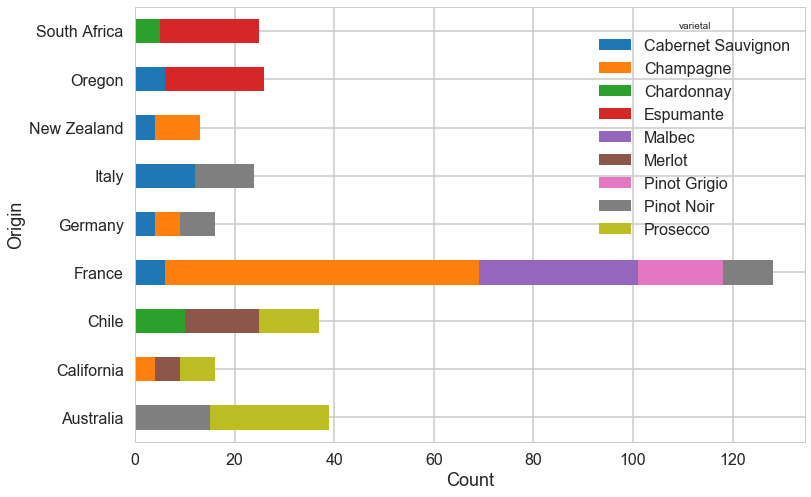

In [17]:
# Viualize the 'Origin' and 'Varietal' of wines
var_orig=df_combined.groupby(['varietal','origin'])['n'].count().unstack().fillna(0)
var_orig.T.plot(kind='barh',figsize=(12,8),stacked=True,fontsize=16)
plt.ylabel('Origin',fontsize=18)
plt.xlabel('Count',fontsize=18);

The bar plot shows that the most offers are for wine from France and wines from France have the most varieties, among which 'Champagne' and 'Malbec' take a large portion in sale offers. Note that 'Malbec' and 'Pinot Grigio' are only offered in France wines.

In [18]:
# Create a table of the number of varieatal offers for each cluster_id
pd.crosstab(df_combined['cluster_id'],df_combined['varietal'])

varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
cluster_id,,,,,,,,,
0,1,0,0,22,16,6,16,0,12
1,0,1,1,0,1,1,0,37,2
2,31,80,14,18,15,13,1,7,29


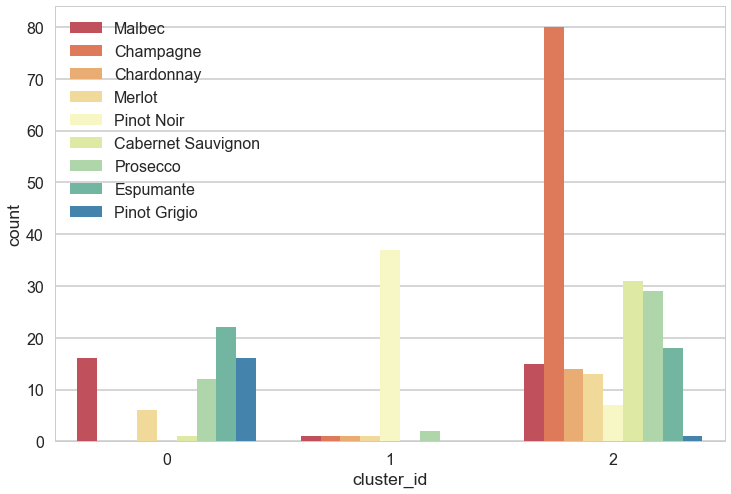

In [19]:
# Visualize the taste ('varietal') of each cluster
plt.figure(figsize=(12,8))
ax=sns.countplot(x='cluster_id',hue='varietal',data=df_combined,palette='Spectral')
ax.legend(loc=2);

We can tell from the chart that customers with cluster_id=0 have no response to wine offers concerning 'Champagne' and 'Chardonnay' (which is particularly favored by the cluster_2 group), 'Pinot Noir' (which is particularly favored by the cluster_1 group), instead they seem to prefer 'Espunante', 'Malbec' and 'Pinot Grigio'.

Customers with cluster_id=1 like the 'Pinot Noir' offer most. They don't quite care other wine offers. Customers with cluster_id=2 like the wine offer 'Champagne' most and they also like other wine offers except 'Pinot Grigio'.

Based on those observations, offers can be customized on 'varietal' to attract customers in different clusters formed by KMeans model.

In [20]:
# Create a table of the number of offers from various origins for each cluster_id
pd.crosstab(df_combined['cluster_id'],df_combined['origin'])

origin,Australia,California,Chile,France,Germany,Italy,New Zealand,Oregon,South Africa
cluster_id,,,,,,,,,
0,12,0,6,33,0,0,0,11,11
1,13,2,0,7,7,12,1,0,1
2,14,14,31,88,9,12,12,15,13


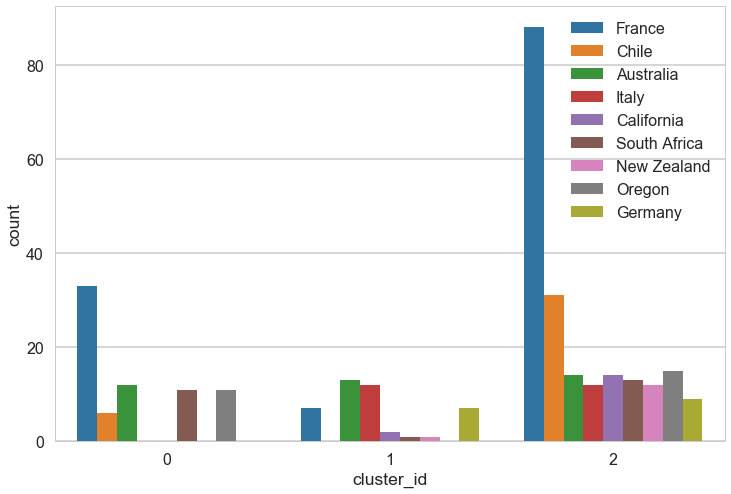

In [21]:
plt.figure(figsize=(12,8))
ax=sns.countplot(x='cluster_id',hue='origin',data=df_combined)
ax.legend(loc=1);

Customers with cluster_id=0 like wines from France, Australia and South Africa, Oregon which produce 'Espunante', the No. 1 choice of this group. Customers in cluster 1 like wines from Italy and France which produce their favorite 'Pinot Noir'. The last group customers like wine offers of all origins. They especially like offers for France wine, which has the most offers for 'Champagne' and provides the most variety of wines.

In [22]:
# Create a table of the number of offers of various order size for each cluster_id
pd.crosstab(df_combined['cluster_id'],df_combined['min_qty'])

min_qty,6,12,72,144
cluster_id,,,,
0,72,1,0,0
1,12,7,11,13
2,26,14,123,45


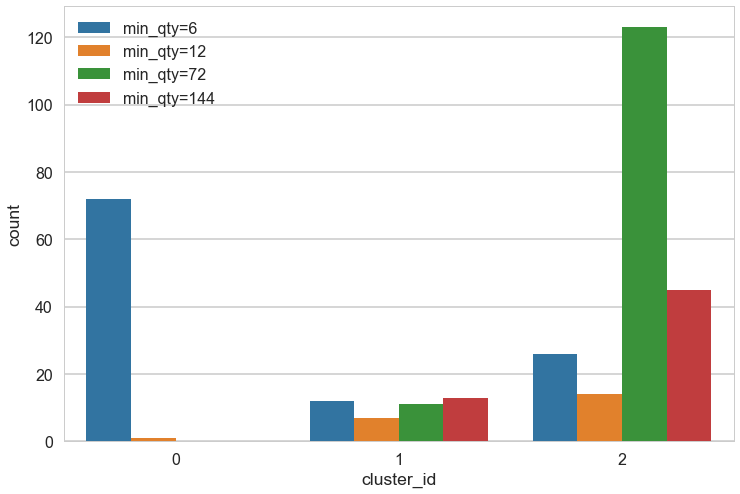

In [23]:
# Visualize the acceptable purchase amount ('min_qty') of each cluster
plt.figure(figsize=(12,8))
ax=sns.countplot(x='cluster_id',hue='min_qty',data=df_combined)#, palette='RdBu'
labels=['min_qty='+ str(i) for i in sorted(df_combined.min_qty.unique())]
ax.legend(labels,loc=2);

cluster_id=0 customers prefer small amount of bottles discount, i.e., min_qty=6 offers; cluster_id=1 customers like every offer regardless the minimum quantity requirement; cluster_id=2 customers prefer large purchase: min_qty=72, 144 offers but they also like to buy smaller amount of wines.

In summary, we explored the relations of wine types ('varietal'),  wine origin ('origin') and minimum quantity requirement ('min_qty') to the three cluster found using KMeans model and we find that:

1. Customers from the first group (cluster_id=0) like 'Espunante', 'Malbec' and 'Pinot Grigio' wines. They like to buy in small amount and they perfer offers of wine from France, Australia and South Africa, Oregon. 

2. Customers in the group (cluster_id=1) like 'Pinot Noir' most, and they buy in various amount. They especially like wines from Italy and France which produce their favorite 'Pinot Noir'.

3. Customers in the group (cluster_id=2) take more than 60% of all the customers. They like all wine offers from all the origins. They like 'Champagne' most and 'Pinot Grigio' least. They like to buy both large and small amount. Their favorite minimum quantity requirement is 72 bottles. 

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

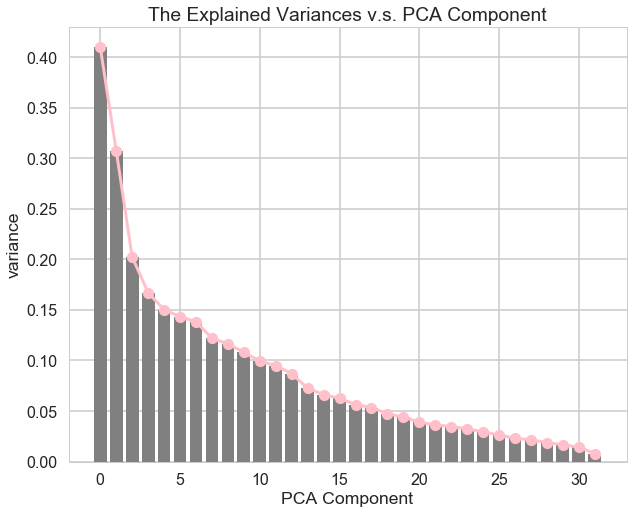

In [24]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Plot the explained variances
features =range(pca.n_components_)
plt.figure(figsize=(10,8))
plt.bar(features, pca.explained_variance_,color='gray')
#sns.barplot(np.arange(33), pca.explained_variance_, color="grey")

plt.plot(features, pca.explained_variance_,'-o',color='pink',linewidth=3)



plt.xlabel('PCA Component')
plt.ylabel('variance')
plt.title('The Explained Variances v.s. PCA Component');


The figure above indicates that the explained variances start to drop slowly at the 3rd component. So the optimal value for the dimension should be 3.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [25]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score


# Define a function to produce the silhouette_score and visualize clustering using PCA
def myfun(clf):
    cluster_labels=clf.fit_predict(x_cols)
    n_clusters=np.unique(cluster_labels).size
    ss=silhouette_score(x_cols, cluster_labels)
    
    
    print('n_clusters: ',n_clusters)
    print('silhouette score: %0.2f'%ss)
    
    # visualize clusters using PCA
    df=pd.DataFrame({'x':PCA_1 ,'y':PCA_2,'cluster_id':cluster_labels})
    sns.lmplot('x','y',hue='cluster_id',data=df,fit_reg=False)

**Clustering using the Affinity propagation algorithms**

n_clusters:  14
silhouette score: 0.12


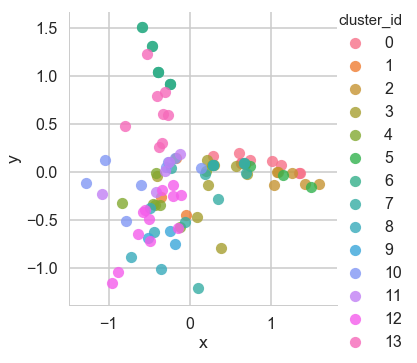

In [26]:
myfun(AffinityPropagation(damping=0.5))

**Clustering using the Spectral clustering algorithms**

n_clusters:  3
silhouette score: 0.10


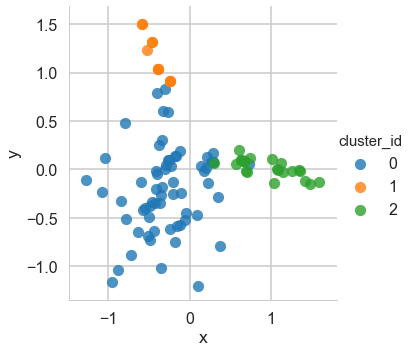

In [27]:
myfun(SpectralClustering(n_clusters=3))

**Clustering using the Agglomerative clustering algorithms**

n_clusters:  2
silhouette score: 0.08


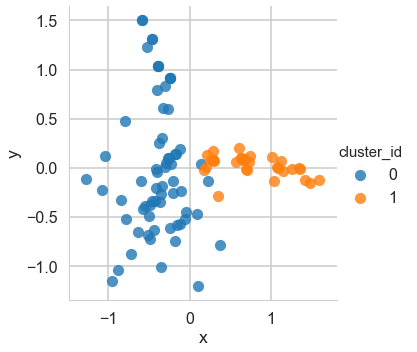

In [28]:
myfun(AgglomerativeClustering())

**Clustering using the DBSCAN algorithms**

n_clusters:  2
silhouette score: 0.23


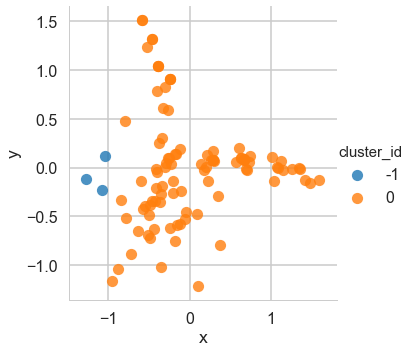

In [29]:
myfun(DBSCAN(eps=2.0,min_samples=3))

The above plots show that the silhouette score yielded by DBSCAN algorithm is the highest.